PyQuil is for constructing and running quantum programs on real quantum computers. With the release of pyQuil 2, we have changed parts of the API to better reflect that focus. Instead of swapping between a QVMConnection and a QPUConnection, you will primarily deal with a QuantumComputer with consistent API and behavior regardless of

    QVM / QPU
    Presence of noise model
    Device topology



In [1]:
from pyquil import Program
from pyquil.gates import *

In [2]:
def ghz_state(qubits):
    """Create a GHZ state on the given list of qubits by applying
    a Hadamard gate to the first qubit followed by a chain of CNOTs
    """
    program = Program()
    program += H(qubits[0])
    for q1, q2 in zip(qubits, qubits[1:]):
        program += CNOT(q1, q2)
    return program

In [3]:
program = ghz_state(qubits=[0, 1, 2])
print(program)

H 0
CNOT 0 1
CNOT 1 2



### Debugging with wavefunction simulator

In [4]:
from pyquil.api import WavefunctionSimulator
wfn = WavefunctionSimulator().wavefunction(program)
print(wfn)

(0.7071067812+0j)|000> + (0.7071067812+0j)|111>


One can't look at the wavefunction (like above) from a real quantum computer. However, one can expect to always sample the bitstrings.

In [5]:
from pyquil import get_qc
qc = get_qc('3q-qvm')
qc

QuantumComputer[name="3q-qvm"]

In [6]:
qc.qubits()

[0, 1, 2]

### Sampling with run_and_measure

In [7]:
bitstrings = qc.run_and_measure(program, trials=10)
bitstrings

{0: array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1]),
 1: array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1]),
 2: array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1])}

In [8]:
import numpy as np
bitstring_array = np.vstack(bitstrings[q] for q in qc.qubits()).T
sums = np.sum(bitstring_array, axis=1)
sums


array([3, 0, 3, 0, 3, 3, 0, 0, 0, 3])

In [9]:
sample_is_ghz = np.logical_or(sums == 0, sums == 3)
sample_is_ghz

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [10]:
np.all(sample_is_ghz)

True

#### All qubits are measured by run_and_measure scheme

In [11]:
qc = get_qc('4q-qvm')
bitstrings = qc.run_and_measure(Program(X(0), X(1), X(2)), trials=10)
bitstrings

{0: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 1: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 2: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 3: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [12]:
# Stacking everything
np.vstack(bitstrings[q] for q in qc.qubits()).T

array([[1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0]])

In [13]:
# Stacking what you want (contrast with above)
qubits = [0, 1, 2]
np.vstack(bitstrings[q] for q in qubits).T

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

### List quantum computers

In [14]:
from pyquil import list_quantum_computers
# TODO: unauthenticated endpoint
list_quantum_computers()


['Aspen-3-14Q-A',
 'Aspen-3-4Q-B',
 'Aspen-3-2Q-C',
 'Aspen-3-3Q-B',
 'Aspen-3-4Q-F',
 'Aspen-3-5Q-B',
 'Aspen-3-6Q-B',
 'Aspen-3-7Q-B',
 'Aspen-3-8Q-B',
 'Aspen-3-9Q-B',
 'Aspen-3-10Q-B',
 'Aspen-4-2Q-A',
 'Aspen-4-3Q-A',
 'Aspen-4-4Q-A',
 'Aspen-4-5Q-A',
 'Aspen-4-6Q-A',
 'Aspen-4-7Q-A',
 'Aspen-4-8Q-A',
 'Aspen-4-9Q-A',
 'Aspen-4-10Q-A',
 'Aspen-4-11Q-A',
 'Aspen-4-12Q-A',
 'Aspen-4-13Q-A',
 'Aspen-4-14Q-B',
 '9q-square-qvm',
 '9q-square-noisy-qvm']

### Working with noise models

In [15]:
qc = get_qc('3q-noisy-qvm')
bitstrings = qc.run_and_measure(program, trials=10)
bitstrings

{0: array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1]),
 1: array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1]),
 2: array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1])}

In [16]:
bitstring_array = np.vstack(bitstrings[q] for q in qc.qubits()).T
sums = np.sum(bitstring_array, axis=1)
sums

array([0, 0, 0, 0, 3, 0, 0, 3, 2, 3])

In [17]:
# Noise means now we measure things other than 000 or 111
np.all(np.logical_or(sums == 0, sums == 3))

False

### Topology of the quantum computer

/home/kishor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


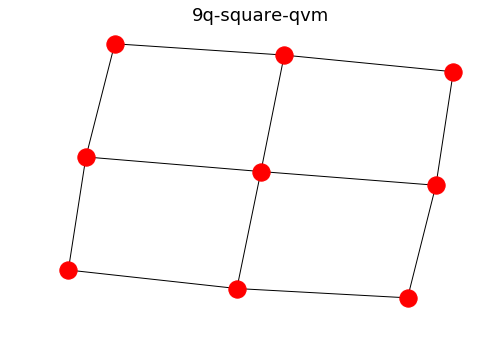

In [18]:
qc = get_qc('9q-square-qvm')
%matplotlib inline
import networkx as nx
nx.draw(qc.qubit_topology())
from matplotlib import pyplot as plt
_ = plt.title('9q-square-qvm', fontsize=18)

#### Defining arbitrary topology

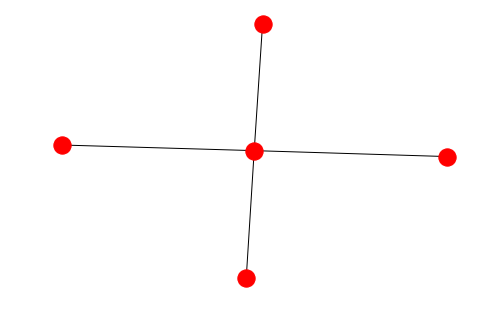

In [19]:
topology = nx.from_edgelist([
    (10, 2),
    (10, 4),
    (10, 6),
    (10, 8),
])
from pyquil.device import NxDevice
device = NxDevice(topology)

from pyquil.api._qac import AbstractCompiler
class MyLazyCompiler(AbstractCompiler):
    def quil_to_native_quil(self, program):
        return program

    def native_quil_to_executable(self, nq_program):
        return nq_program


from pyquil.api import QuantumComputer, QVM, ForestConnection
my_qc = QuantumComputer(
    name='my-qvm',
    qam=QVM(connection=ForestConnection()),
    device=device,
    compiler=MyLazyCompiler(),
)

nx.draw(my_qc.qubit_topology())


In [20]:
my_qc.run_and_measure(Program(X(10)), trials=5)

{2: array([0, 0, 0, 0, 0]),
 4: array([0, 0, 0, 0, 0]),
 6: array([0, 0, 0, 0, 0]),
 8: array([0, 0, 0, 0, 0]),
 10: array([1, 1, 1, 1, 1])}